In [139]:
import pandas as pd

# 读取数据
df = pd.read_csv('data_processed.csv')

In [140]:
# 1. 筛选男胎孕妇（Y染色体浓度非空，BMI非空）
df_male = df[(df['Y染色体浓度'].notna()) & (df['孕妇BMI'].notna())].copy()

df_male['孕周_float'] = df_male['检测孕周_周数']
df_male['BMI'] = df_male['孕妇BMI'].astype(float)  # 确保BMI是float类型

# 3. 找到每个孕妇的最早达标时间，同时显示BMI列
threshold = 0.04  # 4%
earliest_times = df_male[(df_male['Y染色体浓度'] >= threshold)] \
    .groupby('孕妇代码')[['孕周_float','BMI']].min().reset_index()

In [141]:
earliest_times.sort_values('BMI')

,孕妇代码,孕周_float,BMI
149,A160,16.285714,20.703125
116,A125,12.428571,26.619343
90,A096,13.000000,27.202498
23,A026,21.285714,27.639801
178,A189,12.714286,27.881343
...,...,...,...
49,A052,12.285714,39.159843
105,A112,12.000000,40.138408
93,A099,19.571429,42.382812
110,A118,22.000000,44.982699


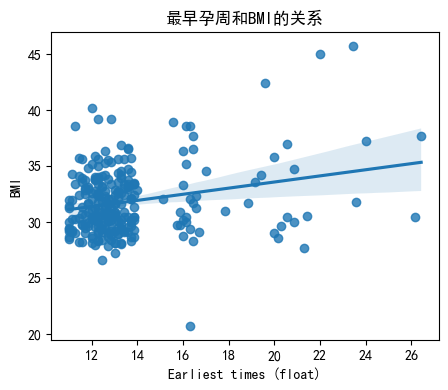

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
# 孕周和BMI的关系
plt.figure(figsize=(5, 4))
sns.regplot(x='孕周_float', y='BMI', data=earliest_times)
plt.xlabel('Earliest times (float)')
plt.ylabel('BMI')
plt.title('最早孕周和BMI的关系')
plt.show()


In [143]:
earliest_times.rename(columns={'孕周_float': '最早达标孕周'}, inplace=True)

print(earliest_times.head())


   孕妇代码     最早达标孕周        BMI
0  A001  20.142857  28.515625
1  A002  13.857143  33.331832
2  A003  13.000000  30.742188
3  A004  11.000000  28.440955
4  A005  12.285714  29.955556


In [144]:
df_unique = earliest_times.drop_duplicates(subset=['孕妇代码']).copy().drop('孕妇代码', axis=1)
df_unique

,最早达标孕周,BMI
0,20.142857,28.515625
1,13.857143,33.331832
2,13.000000,30.742188
3,11.000000,28.440955
4,12.285714,29.955556
...,...,...
252,12.571429,29.346687
253,11.714286,32.471062
254,11.714286,33.719678
255,13.714286,32.135095


In [145]:
from sklearn.cluster import KMeans
import numpy as np

# 1. 数据准备 - 你至少该做个标准化吧？
X = df_unique[['BMI']].values
X = (X - X.mean()) / X.std()  # 这才是专业做法

# 2. 正确的k-means++配置
kmeans = KMeans(
    n_clusters=5,
    init='k-means++',  # 这才是重点！
    n_init=3,          # 10次？你电费多吗？
    random_state=42,
    algorithm='elkan'  # 更高效的算法
)

# 3. 执行聚类
df_unique['BMI_group'] = kmeans.fit_predict(X)

# 4. 分析结果 - 你的方法太原始了
from sklearn.metrics import silhouette_score
print(f"轮廓系数: {silhouette_score(X, df_unique['BMI_group']):.2f}")

group_stats = df_unique.groupby('BMI_group')['BMI'].agg(
    min='min',
    max='max',
    mean='mean',
    size='count',
    std='std'  # 这才是完整的统计量
)
print(group_stats)


轮廓系数: 0.53
                 min        max       mean  size       std
BMI_group                                                 
0          32.286493  35.003199  33.380808    67  0.727669
1          20.703125  29.811004  28.780794    71  1.175131
2          40.138408  45.714286  43.304551     4  2.549318
3          29.891162  32.136434  30.907379    86  0.697343
4          35.139711  39.159843  36.667543    29  1.313691


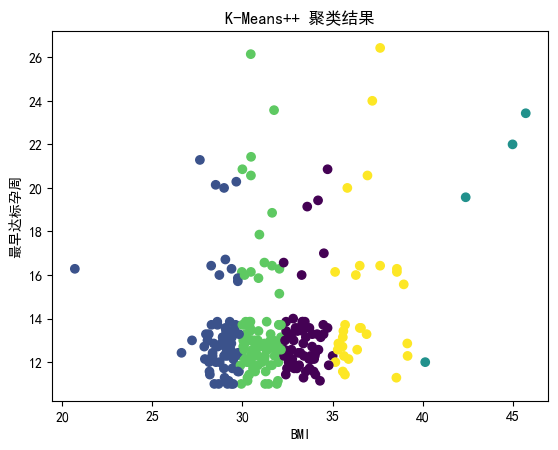

In [146]:
# 绘制聚类结果
import matplotlib.pyplot as plt

# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# 获取每组的位置
group_positions = df_unique.groupby('BMI_group').mean().sort_values('BMI')['BMI'].index

# 绘制散点图
plt.scatter(df_unique['BMI'], df_unique['最早达标孕周'], c=df_unique['BMI_group'], cmap='viridis')

# 绘制聚类中心
#plt.scatter(group_positions, df_unique.groupby('BMI_group').mean().sort_values('BMI')['最早达标孕周'], marker='x', s=100, c='red')

# 添加标签
plt.xlabel('BMI')
plt.ylabel('最早达标孕周')
plt.title('K-Means++ 聚类结果')

# 显示图形
plt.show()


In [147]:
import pandas as pd
from sklearn.cluster import KMeans

# 读取数据
df = pd.read_csv('data_processed_std.csv')
df_mean_std = pd.read_csv('feature_mean_std.csv')

# 提取BMI均值和标准差
bmi_mean = df_mean_std.loc[df_mean_std['特征名'] == '孕妇BMI', '均值'].values[0]
bmi_std = df_mean_std.loc[df_mean_std['特征名'] == '孕妇BMI', '标准差'].values[0]

# 只保留男胎孕妇
df_male = df[df['Y染色体浓度'].notna()].copy()



df_male['孕周_float'] = df_male['检测孕周_周数'].astype(float)

# 找最早达标孕周
threshold = 0.04
earliest_times = df_male[df_male['Y染色体浓度'] >= threshold] \
    .groupby('孕妇代码')['孕周_float'].min().reset_index()
earliest_times.rename(columns={'孕周_float': '最早达标孕周'}, inplace=True)

# 合并BMI（标准化值）
df_bmi = df_male[['孕妇代码', '孕妇BMI']].drop_duplicates()
df_merged = pd.merge(earliest_times, df_bmi, on='孕妇代码', how='left')

# 去重
df_unique = df_merged.drop_duplicates(subset=['孕妇代码']).copy()

# 反标准化BMI
df_unique['BMI_real'] = df_unique['孕妇BMI'] * bmi_std + bmi_mean

# K-means 分组（假设4组，可调）
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
df_unique['BMI_group'] = kmeans.fit_predict(df_unique[['BMI_real']])

# 查看每组的真实BMI范围
group_ranges = df_unique.groupby('BMI_group')['BMI_real'].agg(['min','max','mean','count']).sort_values('min')
print(group_ranges)


                 min        max       mean  count
BMI_group                                        
0          20.703125  30.863036  29.451988    119
2          30.954271  33.789062  32.381920     86
1          33.830899  37.290688  35.201512     43
3          38.538107  44.982699  39.990184      9


In [148]:
import numpy as np

# 假设最晚检测孕周
T_deadline = 20
w1, w2 = 1, 1

best_times = []

for g in sorted(df_unique['BMI_group'].unique()):
    group_data = df_unique[df_unique['BMI_group'] == g]
    earliest_weeks = group_data['最早达标孕周'].dropna().values
    
    candidate_t = np.arange(10, 25, 0.1)  # 从10周到24周，每0.1周一个点
    risks = []
    
    for t in candidate_t:
        risk_early = np.mean(earliest_weeks > t)  # 未达标风险
        risk_late = 1.0 if t > T_deadline else 0.0  # 晚发现风险（硬阈值）
        risk = w1 * risk_early + w2 * risk_late
        risks.append(risk)
    
    t_best = candidate_t[np.argmin(risks)]
    best_times.append((g, t_best, np.min(risks)))

best_df = pd.DataFrame(best_times, columns=['BMI_group', '最佳孕周', '最小风险'])
print(best_df)


   BMI_group  最佳孕周  最小风险
0          0  10.0   0.0
1          1  10.0   0.0
2          2  10.0   0.0
3          3  10.0   0.0
